Base models without a grid search will first be fitted to get a sense of which work best with the imbalanced dataset. Each model will be fitted with various iterations of the dataset. Then, models are down selected and greater tuning through grid searches occur before finally settling on a final model.

We look at two different datasets (one with more variables) and then use both AUC and Recall/Sensitivity as the scoring metric.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import pickle 
import os 


%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay, auc, PrecisionRecallDisplay

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
def action_with_warnings():
    warnings.warn("should not appear")

with warnings.catch_warnings(record=True):
    action_with_warnings()

# Data Prep

## Load data

In [4]:
data1 = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/c71ba6cf-b4e0-4e60-98f0-48aeaf4c6460/download/foia-7afy2020-present-asof-220331.csv', 
                    encoding = "ISO-8859-1", low_memory = False)

data2 = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/02e2e83a-2af1-4ce8-91db-85e20ffadbf7/download/foia-7afy2010-fy2019-asof-220331.csv', 
                    encoding = "ISO-8859-1", low_memory = False)

data3 = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/95d6972c-38df-4ecf-8f0a-eed224e8b02c/download/foia-7afy2000-fy2009-asof-220331.csv', 
                    encoding = "ISO-8859-1", low_memory = False)

data = pd.concat([data1, data2, data3], ignore_index=True).reset_index(drop=True)

In [5]:
# subset to observations with the LoanStatus PIF or CHGOFF aka paid in full or charged off. We don't care about loans that are currently being paid back
df = data[(data['LoanStatus'] == 'PIF') | (data['LoanStatus'] == 'CHGOFF')].drop_duplicates().reset_index(drop=True)

# convert PIF to 0 and CHGOFF to 1
df.loc[df['LoanStatus'] == 'PIF', 'LoanStatus'] = '0' 
df.loc[df['LoanStatus'] == 'CHGOFF', 'LoanStatus'] = '1'
df['LoanStatus'] = df['LoanStatus'].astype(int)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931860 entries, 0 to 931859
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AsOfDate               931860 non-null  int64  
 1   Program                931860 non-null  object 
 2   BorrName               931844 non-null  object 
 3   BorrStreet             931840 non-null  object 
 4   BorrCity               931850 non-null  object 
 5   BorrState              931850 non-null  object 
 6   BorrZip                931860 non-null  int64  
 7   BankName               931860 non-null  object 
 8   BankFDICNumber         851310 non-null  float64
 9   BankNCUANumber         20674 non-null   float64
 10  BankStreet             931824 non-null  object 
 11  BankCity               931824 non-null  object 
 12  BankState              931818 non-null  object 
 13  BankZip                931824 non-null  object 
 14  GrossApproval          931850 non-nu

## Create core dataset

In [7]:
core = df[['LoanStatus', 'BankName', 'RevolverStatus', 'TermInMonths', 'InitialInterestRate', 'ApprovalFiscalYear', 'NaicsCode', 'subpgmdesc', 'BankState', 'BorrState']].copy().dropna()

# Same state for Bank and Borrower
core['BorrBankSameState'] = 0
core.loc[core.BankState == core.BorrState, 'BorrBankSameState'] = 1

# Number of total loans, total defaults, and percentage of default for each bank
df_BankDefaults = pd.merge(pd.DataFrame(df.groupby('BankName')['LoanStatus'].count()).reset_index().rename(columns={'LoanStatus':'TotLoanCounts'}), 
                           pd.DataFrame(df.groupby('BankName')['LoanStatus'].sum()).reset_index().rename(columns={'LoanStatus':'TotDefaultCounts'}), 
                           how='inner', on='BankName')
core = pd.merge(core[['LoanStatus', 'BankName', 'RevolverStatus', 'TermInMonths', 'InitialInterestRate', 'BorrBankSameState', 'ApprovalFiscalYear', 'NaicsCode', 'subpgmdesc']], 
                df_BankDefaults, 
                how='inner', 
                on='BankName')
core['TotPctDefault'] = core['TotDefaultCounts']/core['TotLoanCounts']

# Number of yearly loans, yearly defaults, and percentage of default for each bank for each year of issuance 
df_BankDefaultsYearly = pd.merge(pd.DataFrame(df.groupby(['BankName', 'ApprovalFiscalYear'])['LoanStatus'].count()).reset_index().rename(columns={'LoanStatus':'YearlyLoanCounts'}), 
                           pd.DataFrame(df.groupby(['BankName', 'ApprovalFiscalYear'])['LoanStatus'].sum()).reset_index().rename(columns={'LoanStatus':'YearlyDefaultCounts'}), 
                           how='inner', on=['BankName', 'ApprovalFiscalYear'])

df_BankDefaultsYearly = df_BankDefaultsYearly.sort_values(['BankName', 'ApprovalFiscalYear'], axis=0, ascending=True)

df_BankDefaultsYearly['CumulativeDefault'] = df_BankDefaultsYearly.groupby(['BankName'])['YearlyDefaultCounts'].transform(pd.Series.cumsum)
df_BankDefaultsYearly['CumulativeLoansIssued'] = df_BankDefaultsYearly.groupby(['BankName'])['YearlyLoanCounts'].transform(pd.Series.cumsum)


core = pd.merge(core[['LoanStatus', 'BankName', 'ApprovalFiscalYear', 'RevolverStatus', 'TermInMonths', 'InitialInterestRate', 'BorrBankSameState',
                     'TotPctDefault', 'TotDefaultCounts', 'TotLoanCounts', 'NaicsCode', 'subpgmdesc']], 
                df_BankDefaultsYearly, 
                how='inner', 
                on=['BankName', 'ApprovalFiscalYear'])

core['YearlyPctDefault'] = core['YearlyDefaultCounts']/core['YearlyLoanCounts']
core['CumulativeYearlyPctDefault'] = core['CumulativeDefault']/core['CumulativeLoansIssued']

## Create features to test

In [8]:
# Just the community express dummy indicator
core_small = core.copy()
core_small['subpgmdesc_community_express'] = 0
core_small.loc[core_small.subpgmdesc == 'Community Express', 'subpgmdesc_community_express'] = 1

# Dummy variables for all of the sub program descriptions
core_large = pd.merge(core.drop('subpgmdesc', axis=1), pd.get_dummies(core['subpgmdesc'], prefix = 'subpgmdesc_', drop_first=True), how='inner', left_index = True, right_index = True)

In [9]:
# core_small gets none of the naics codes
core_small.drop('NaicsCode', axis=1, inplace=True)

# core_large gets all of the naics codes
core_large['NaicsCode'] = core_large['NaicsCode'].astype(str)
core_large['NaicsCode'] = core_large['NaicsCode'].str.slice(stop=2)
core_large['NaicsCode'] = core_large['NaicsCode'].astype(int)
core_large = pd.merge(core_large.drop('NaicsCode', axis=1), pd.get_dummies(core_large['NaicsCode'], prefix = 'NaicsCode_', drop_first=True), how='inner', left_index = True, right_index = True) 

In [10]:
# core_small just has dummy variables for 2006 and 2007
core_small['Year2006'] = 0
core_small.loc[core_small.ApprovalFiscalYear == 2006, 'Year2006'] = 1

core_small['Year2007'] = 0
core_small.loc[core_small.ApprovalFiscalYear == 2007, 'Year2007'] = 1

In [11]:
# core_large has dummy variables for all years
core_large = pd.merge(core_large.drop('ApprovalFiscalYear', axis=1), pd.get_dummies(core_large['ApprovalFiscalYear'], prefix = 'ApprovalFiscalYear_', drop_first=True), how='inner', left_index = True, right_index = True) 

In [12]:
# remove unnecessary variables
core_small.drop(['BankName', 'ApprovalFiscalYear', 'subpgmdesc'], axis=1, inplace=True)
core_large.drop(['BankName'], axis=1, inplace=True)

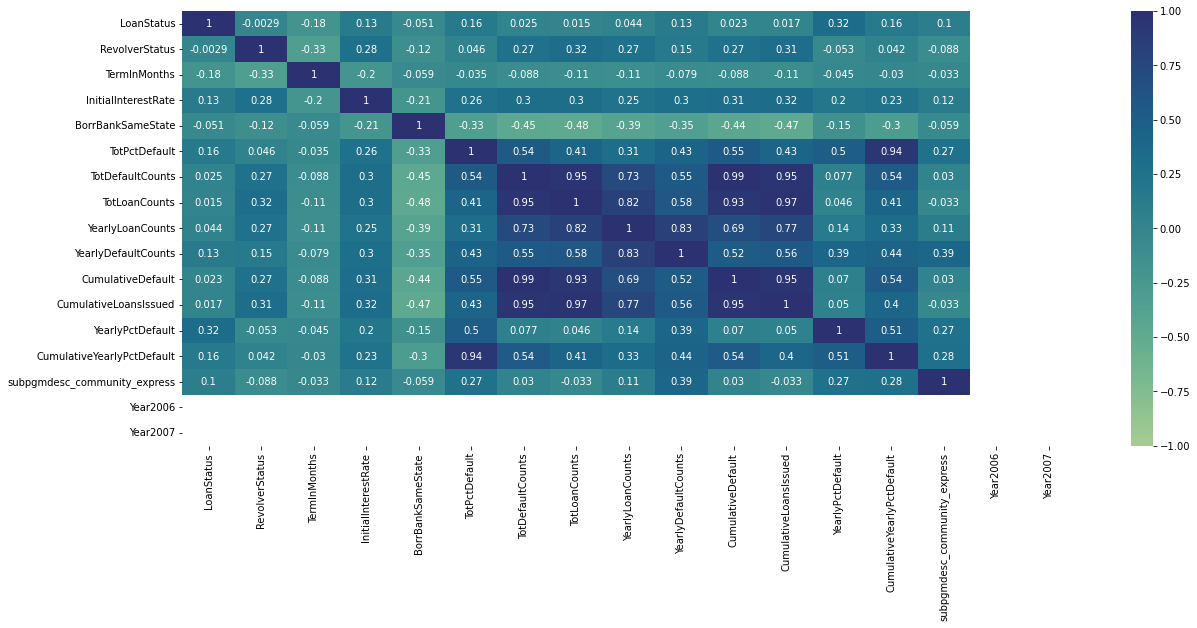

In [13]:
plt.figure(figsize=(20,8))
sns.heatmap(core_small.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

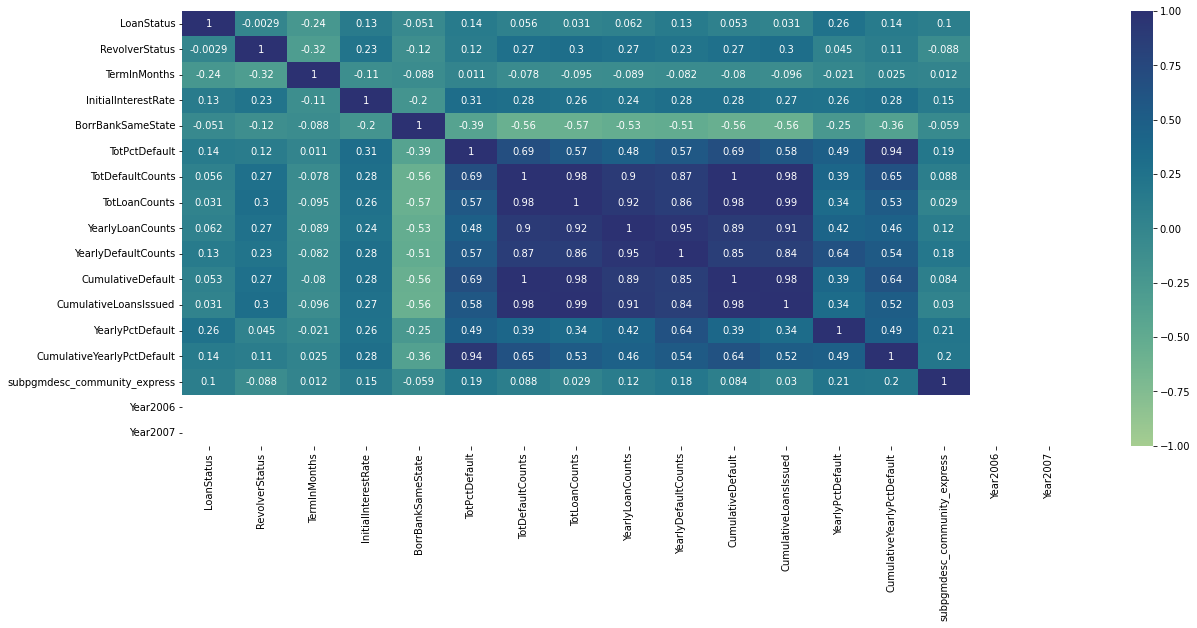

In [14]:
plt.figure(figsize=(20,8))
sns.heatmap(core_small.corr(method='spearman'), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [15]:
core_small.columns

Index(['LoanStatus', 'RevolverStatus', 'TermInMonths', 'InitialInterestRate',
       'BorrBankSameState', 'TotPctDefault', 'TotDefaultCounts',
       'TotLoanCounts', 'YearlyLoanCounts', 'YearlyDefaultCounts',
       'CumulativeDefault', 'CumulativeLoansIssued', 'YearlyPctDefault',
       'CumulativeYearlyPctDefault', 'subpgmdesc_community_express',
       'Year2006', 'Year2007'],
      dtype='object')

In [24]:
core_small.CumulativeLoansIssued.median()

3437.0

# Models

In [15]:
def compute_eval(actual, pred):
    fpr, tpr, thresholds = roc_curve(actual, pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.show()

## Split

In [16]:
X_train_core_small, X_validation_core_small, y_train_core_small, y_validation_core_small = train_test_split(core_small.iloc[:, 1:], core_small.iloc[:, 0], test_size=0.2, random_state=123)
X_train_core_large, X_validation_core_large, y_train_core_large, y_validation_core_large = train_test_split(core_large.iloc[:, 1:], core_large.iloc[:, 0], test_size=0.2, random_state=123)

## Random Forest

In [38]:
rf_pipe = Pipeline([("model", RandomForestClassifier(class_weight={0: 1, 1: 12}))])

### core_small

In [39]:
cross_val_score(rf_pipe, X_train_core_small, y_train_core_small.ravel(), cv = 5, scoring='recall', n_jobs=3)

array([0.65722211, 0.67029919, 0.67644145, 0.6621086 , 0.66567578])

In [40]:
# Use non cross validation to get a sense of the other scores - focused on recall which is why I calculated using the CV for that.
rf_pipe.fit(X_train_core_small, y_train_core_small.ravel())
rf_predictions = rf_pipe.predict(X_validation_core_small)

In [41]:
print(classification_report(y_validation_core_small, rf_predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     66560
           1       0.80      0.68      0.73      6286

    accuracy                           0.96     72846
   macro avg       0.88      0.83      0.85     72846
weighted avg       0.95      0.96      0.96     72846



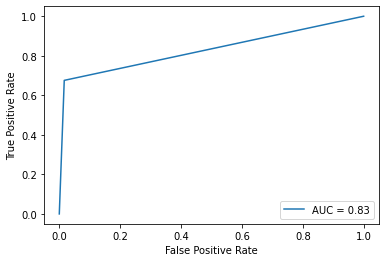

In [42]:
compute_eval(y_validation_core_small, rf_predictions)

### core_large

In [45]:
rf_pipe = Pipeline([("model", RandomForestClassifier(class_weight={0: 1, 1: 12}))])

In [46]:
cross_val_score(rf_pipe, X_train_core_large, y_train_core_large.ravel(), cv = 5, scoring='recall', n_jobs=3)

array([0.61719834, 0.61402814, 0.6154151 , 0.61850971, 0.61097899])

In [47]:
# Use non cross validation to get a sense of the other scores - focused on recall which is why I calculated using the CV for that.
rf_pipe.fit(X_train_core_large, y_train_core_large.ravel())
rf_predictions = rf_pipe.predict(X_validation_core_large)

In [48]:
print(classification_report(y_validation_core_large, rf_predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     66560
           1       0.83      0.62      0.71      6286

    accuracy                           0.96     72846
   macro avg       0.90      0.81      0.84     72846
weighted avg       0.95      0.96      0.95     72846



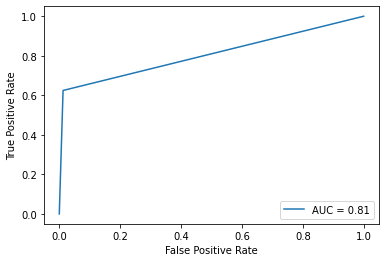

In [49]:
compute_eval(y_validation_core_large, rf_predictions)

## XGBOOST

### core_small

In [50]:
xgb = Pipeline([("model", XGBClassifier(use_label_encoder=False))])

In [70]:
cross_val_score(xgb, X_train_core_small, y_train_core_small.ravel(), cv = 5, scoring='recall', n_jobs=3)

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pa

array([0.78700218, 0.78601149, 0.7850208 , 0.79647245, 0.78616726])

In [52]:
xgb.fit(X_train_core_small, y_train_core_small.ravel())
xgb_predictions = xgb.predict(X_validation_core_small)

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:05:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
print(classification_report(y_validation_core_small, xgb_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     66560
           1       0.81      0.78      0.80      6286

    accuracy                           0.97     72846
   macro avg       0.90      0.88      0.89     72846
weighted avg       0.97      0.97      0.97     72846



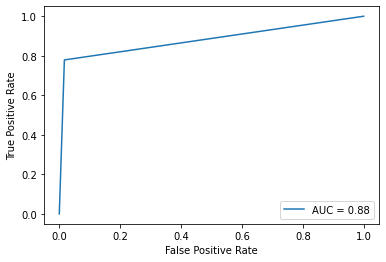

In [54]:
compute_eval(y_validation_core_small, xgb_predictions)

### core_large

In [55]:
xgb = Pipeline([("model", XGBClassifier(use_label_encoder=False))])

In [56]:
cross_val_score(xgb, X_train_core_large, y_train_core_large.ravel(), cv = 5, scoring='recall', n_jobs=3)

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated

array([0.79255003, 0.78918169, 0.80285318, 0.79429251, 0.78775268])

In [57]:
xgb.fit(X_train_core_large, y_train_core_large.ravel())
xgb_predictions = xgb.predict(X_validation_core_large)

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:08:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [58]:
print(classification_report(y_validation_core_large, xgb_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     66560
           1       0.83      0.79      0.81      6286

    accuracy                           0.97     72846
   macro avg       0.90      0.89      0.90     72846
weighted avg       0.97      0.97      0.97     72846



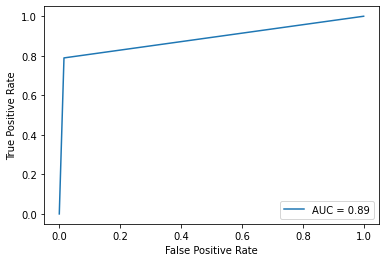

[17:04:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [59]:
compute_eval(y_validation_core_large, xgb_predictions)

## Refine Model

XGBOOST classifier with both datasets that exclude the interest rate (but have double the observations) perform the best. I will be using grid search to determine the optimal hyper-parameters 

In [17]:
xgb = Pipeline([("model", XGBClassifier(use_label_encoder=False, verbosity = 1))])

In [18]:
xgb_params = {'model__scale_pos_weight': [1, 2, 5],
              'model__grow_policy': ['depthwise', 'lossguide'],
              'model__n_estimators': [50, 100, 300]
             }

### XBOOST - core_small

In [71]:
xgb_small_search = GridSearchCV(estimator=xgb, param_grid=xgb_params, verbose = 1, scoring = 'recall', n_jobs=3)
xgb_small_search.fit(X_train_core_small, y_train_core_small)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated

[17:19:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:21:08] WARNING: /home

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:19:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:21:08] WARNING: /home

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:19:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:21:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:21:28] WARNING: /home

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated

[17:49:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                          

In [72]:
print("Best parameter (CV score=%0.3f):" % xgb_small_search.best_score_)
print(xgb_small_search.best_params_)

Best parameter (CV score=0.919):
{'model__grow_policy': 'depthwise', 'model__n_estimators': 50, 'model__scale_pos_weight': 5}


### XBOOST - core_large

In [19]:
xgb_large_search = GridSearchCV(estimator=xgb, param_grid=xgb_params, verbose = 1, scoring = 'roc_auc', n_jobs=3)
xgb_large_search.fit(X_train_core_large, y_train_core_large)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pa

[18:43:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:07] WARNING: /home

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:43:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:06] WARNING: /home

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:43:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:10] WARNING: /home

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated

[19:36:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                          

In [20]:
print("Best parameter (CV score=%0.3f):" % xgb_large_search.best_score_)
print(xgb_large_search.best_params_)

Best parameter (CV score=0.985):
{'model__grow_policy': 'depthwise', 'model__n_estimators': 300, 'model__scale_pos_weight': 1}
[19:18:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:25:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was cha

## Holistic Evaluation

### Small core

In [21]:
xgb = Pipeline([("model", XGBClassifier(use_label_encoder=False,
                                       grow_policy = 'depthwise',
                                       n_estimators = 50,
                                       scale_pos_weight = 5))])

In [22]:
cross_val_score(xgb, X_train_core_small, y_train_core_small.ravel(), cv = 5, scoring='recall', n_jobs=3)

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pa

array([0.91737666, 0.91935803, 0.9239152 , 0.91954023, 0.91696393])

In [23]:
xgb.fit(X_train_core_small, y_train_core_small.ravel())
xgb_predictions = xgb.predict(X_validation_core_small)

[19:42:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
print(classification_report(y_validation_core_small, xgb_predictions))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     66560
           1       0.65      0.91      0.76      6286

    accuracy                           0.95     72846
   macro avg       0.82      0.93      0.87     72846
weighted avg       0.96      0.95      0.95     72846



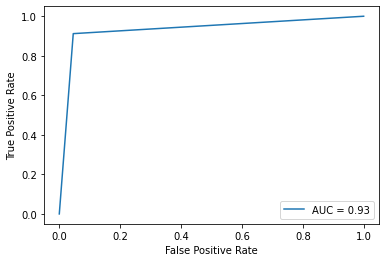

In [25]:
compute_eval(y_validation_core_small, xgb_predictions)

### Large core

In [26]:
xgb = Pipeline([("model", XGBClassifier(use_label_encoder=False,
                                       grow_policy = 'depthwise',
                                       n_estimators = 300,
                                       scale_pos_weight = 1))])

In [27]:
cross_val_score(xgb, X_train_core_large, y_train_core_large.ravel(), cv = 5, scoring='recall', n_jobs=3)

/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jhancuch/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated

array([0.80364573, 0.80542897, 0.80582524, 0.80776853, 0.79845422])

In [28]:
xgb.fit(X_train_core_large, y_train_core_large.ravel())
xgb_predictions = xgb.predict(X_validation_core_large)

[19:48:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
print(classification_report(y_validation_core_large, xgb_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     66560
           1       0.83      0.80      0.81      6286

    accuracy                           0.97     72846
   macro avg       0.90      0.89      0.90     72846
weighted avg       0.97      0.97      0.97     72846



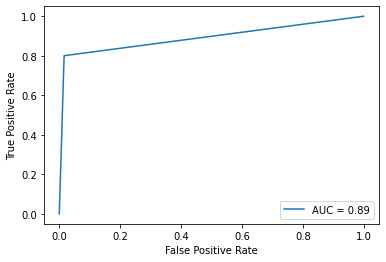

In [30]:
compute_eval(y_validation_core_large, xgb_predictions)

## Export
Export XGBoost model to be able to serve it on GCP application

In [31]:
xgb = XGBClassifier(use_label_encoder=False,
                    grow_policy = 'depthwise',
                    n_estimators = 50, 
                    scale_pos_weight = 5)
xgb.fit(X_train_core_small, y_train_core_small.ravel())

[19:49:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [32]:
artifact_filename = 'model.pkl'

# Save model artifact to local filesystem (doesn't persist)
local_path = artifact_filename
with open(local_path, 'wb') as model_file:
  pickle.dump(xgb, model_file)

In [33]:
xgb.save_model('model.bst')

[19:42:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:44:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:45] WARNING: /home